# Use Case 1: Text Classification with Text Embeddings

Code authored by: Shaw Talebi <br>
Article link: https://towardsdatascience.com/text-embeddings-classification-and-semantic-search-8291746220be <br>
Video link: https://youtu.be/sNa_uiqSlJo

### imports

In [2]:
import openai
import os
from google.colab import userdata
openaikey = userdata.get('OPENAI')
import os
os.environ["OPENAI_API_KEY"] = openaikey

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### import data

In [3]:
df_resume = pd.read_csv('resumes/resumes_train.csv')
df_resume.head()

,resume,role
0,### John Doe\n\n---\n\n#### Summary\nDetail-or...,Data Scientist
1,Creating a resume for a Data Scientist based o...,Data Scientist
2,Creating a resume for a Data Scientist...\n\n-...,Data Scientist
3,Creating a resume for a Data Scientist based o...,Data Scientist
4,## John Doe\n\n---\n\n### Summary:\nData Scien...,Data Scientist


### generate text embeddings

In [4]:
def generate_embeddings(text, my_sk):
    # set credentials
    client = openai.OpenAI(api_key = my_sk)

    # make api call
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )

    # return text embedding
    return response.data

In [5]:
# generate embeddings
text_embeddings = generate_embeddings(df_resume['resume'], openaikey)
# extract embeddings
text_embedding_list = [text_embeddings[i].embedding for i in range(len(text_embeddings))]

### Store embeddings in df

In [6]:
# define df column names
column_names = ["embedding_" + str(i) for i in range(len(text_embedding_list[0]))]

# store text embeddings in dataframe
df_train = pd.DataFrame(text_embedding_list, columns=column_names)

# create target variable
df_train['is_data_scientist'] = df_resume['role']=="Data Scientist"
df_train.to_csv('resumes/embeddings_train.csv', index=False)
df_train.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,is_data_scientist
0,0.011923,0.010732,0.044013,0.023081,0.034455,0.000153,-0.020562,0.034800,-0.023785,-0.000629,...,0.043321,-0.029885,0.016449,0.001582,0.017499,0.010769,-0.037295,0.011022,0.001667,True
1,0.005887,0.030654,0.032117,-0.006901,0.008575,-0.034895,-0.015005,0.053421,-0.018737,0.012431,...,0.020039,-0.010435,0.012983,-0.008693,-0.003131,0.004374,-0.025161,0.033382,0.003277,True
2,0.008211,0.016624,0.029623,0.011863,0.014980,-0.028498,-0.011717,0.048397,-0.035791,0.019032,...,0.019437,0.000441,0.018672,0.001213,-0.001257,0.004882,-0.022735,0.022960,0.004629,True
3,0.000980,0.022212,0.049778,0.009431,0.015012,-0.034424,-0.012995,0.058286,-0.031759,0.034229,...,0.020476,-0.012872,0.025500,-0.002258,0.012567,0.000316,-0.032371,0.030463,0.008802,True
4,0.019266,0.003695,0.035332,0.021370,0.037020,-0.022668,-0.023764,0.061641,-0.019442,-0.005267,...,0.023764,-0.006754,0.031400,0.008064,0.017729,0.024810,-0.041002,0.031274,0.000356,True


### Visualize embeddings with PCA

In [7]:
# split variables by predictors and target
X = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]

# apply PCA to predictors (i.e. embeddings)
pca = PCA(n_components=2).fit(X)
print(pca.explained_variance_ratio_)

[0.13940503 0.1135246 ]


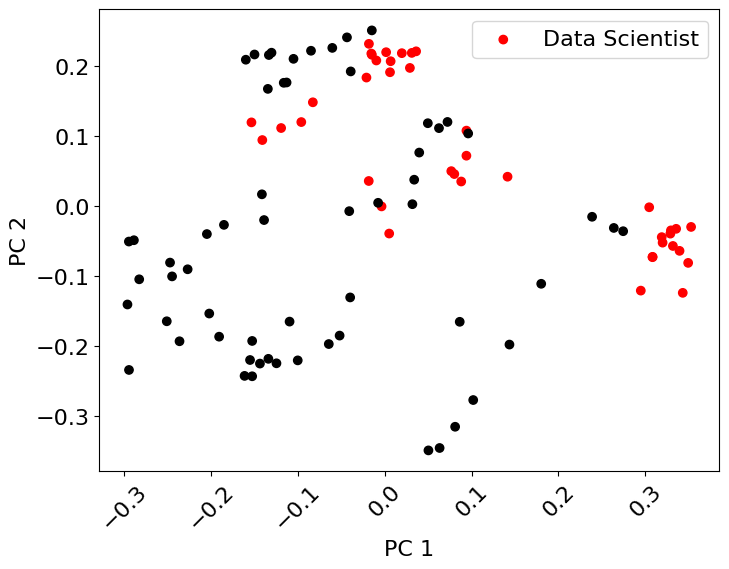

In [8]:
# plot data along PCA components
c_arr = np.array(["k"] * len(y))
c_arr[y] = "r"

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=c_arr)
plt.legend(["Data Scientist"])
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### Train Random Forest Model

In [9]:
# train rf model
clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X, y)
clf.score(X,y) # model accuracy for training data

1.0

In [10]:
# AUC value for training data
auc_val = roc_auc_score(y, clf.predict_proba(X)[:,1])
auc_val

1.0

In [11]:
# print feature importance ranking
feature_importances = pd.Series(clf.feature_importances_, index=column_names)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print(feature_importances_sorted[:25])

embedding_786     0.039140
embedding_500     0.034219
embedding_464     0.030234
embedding_1135    0.025598
embedding_72      0.025157
embedding_914     0.023709
embedding_792     0.021633
embedding_291     0.021493
embedding_1129    0.019163
embedding_725     0.019160
embedding_526     0.018982
embedding_863     0.018442
embedding_181     0.017756
embedding_162     0.016688
embedding_294     0.016686
embedding_1020    0.014972
embedding_639     0.014808
embedding_630     0.014567
embedding_1357    0.014073
embedding_129     0.013136
embedding_99      0.012933
embedding_1199    0.012847
embedding_229     0.012758
embedding_571     0.012290
embedding_173     0.011248
dtype: float64


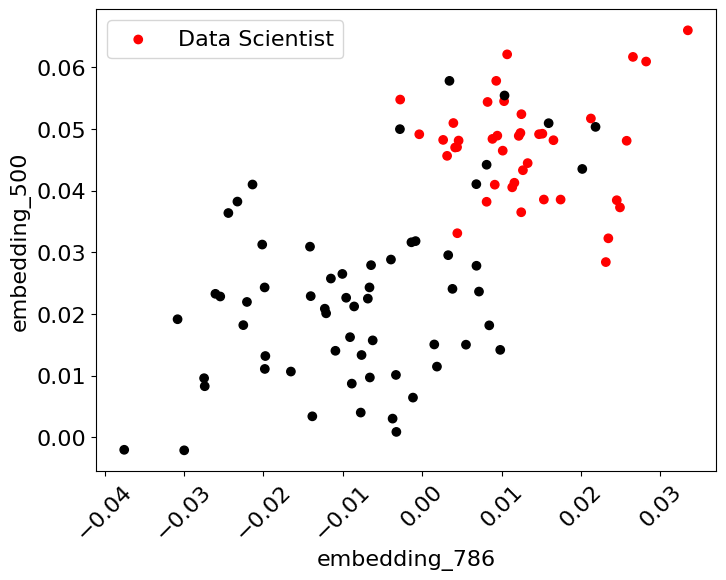

In [12]:
# plot data along top 2 most important features
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(X[feature_importances_sorted.index[0]], X[feature_importances_sorted.index[1]], c=c_arr)
plt.legend(["Data Scientist"])
plt.xticks(rotation = 45)
plt.xlabel(feature_importances_sorted.index[0])
plt.ylabel(feature_importances_sorted.index[1])
plt.show()

#### evaluate model on testing data

In [14]:
# import testing data
df_resume = pd.read_csv('resumes/resumes_test.csv')

# generate embeddings
text_embedding_list = generate_embeddings(df_resume['resume'], openaikey)
text_embedding_list = [text_embedding_list[i].embedding for i in range(len(text_embedding_list))]

# store text embeddings in dataframe
df_test = pd.DataFrame(text_embedding_list, columns=column_names)

# create target variable
df_test['is_data_scientist'] = df_resume['role']=="Data Scientist"
df_test.to_csv('resumes/embeddings_test.csv', index=False)
df_test.head()

# define predictors and target
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [ ]:
# accuracy
clf.score(X_test,y_test)

0.98

In [ ]:
# auc
auc_val = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
auc_val

0.9983333333333333

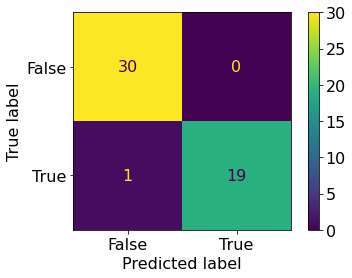

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [15]:
# look at errors
df_errors = df_resume[y_test != clf.predict(X_test)]
print(df_errors.iloc[0,0])

I. **Name:** John Smith

II. **Summary:**
A highly skilled Data Scientist with a strong background in statistical analysis and machine learning. Experienced in interpreting and analyzing complex data sets to drive business decisions and strategies. Proven ability to develop predictive models and algorithms to solve challenging problems.

III. **Professional Experience:**
1. *Data Scientist* at Tech Innovations Inc., San Francisco, CA
   - Developed machine learning models to optimize marketing strategies, resulting in a 15% increase in conversions.
   - Conducted in-depth data analysis to identify trends and insights for product development.

2. *Senior Data Analyst* at Data Solutions Co., New York, NY
   - Led a team to automate data collection processes, saving over 100 man-hours per month.
   - Collaborated with cross-functional teams to provide data-driven solutions for various business challenges.

IV. **Education:**
- *Master of Science in Data Science*, University of California,